In [1]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

In [2]:
from notebook_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

# Datasets

In [4]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30


# Setting params

In [34]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [35]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric

device = "cuda"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device="cuda", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string))
clf_dict= {#'gp': gp_metric
    'knn': knn_metric,
    #             #, 'catboost': catboost_metric
                 'xgb': xgb_metric,
    #         'transformer': transformer_metric,
           'logistic': logistic_metric,
    #           'transformer_mine': partial(transformer_metric, classifier=tabpfn_mine),
    #            'distill_tabpfn':  partial(transformer_metric, classifier=distilled_tabpfn),
    #            'mother_net': partial(transformer_metric, classifier=forward_mlp)
                                            }
#            , 'autosklearn': autosklearn_metric
#              , 'autosklearn2': autosklearn2_metric
             #, 'autogluon': autogluon_metric}

# Baseline Evaluation
This section runs baselines and saves results locally.

In [36]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

/bin/bash: /anaconda/envs/fresh311/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /anaconda/envs/fresh311/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /anaconda/envs/fresh311/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [37]:
clf_dict

{'knn': <function scripts.tabular_baselines.knn_metric(x, y, test_x, test_y, cat_features, metric_used, max_time=300, no_tune=None)>,
 'xgb': <function scripts.tabular_baselines.xgb_metric(x, y, test_x, test_y, cat_features, metric_used, max_time=300, no_tune=None, gpu_id=None)>,
 'logistic': <function scripts.tabular_baselines.logistic_metric(x, y, test_x, test_y, cat_features, metric_used, max_time=300, no_tune=None)>}

In [38]:
# transformers don't have max times
# max_times = [1]

In [39]:
cc_test_datasets_multiclass_df['isNumeric'] = (cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)
name_indexed_dataset = cc_test_datasets_multiclass_df.set_index("name")

numeric_test_datasets = [ds for ds in cc_test_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(numeric_test_datasets)

18

In [40]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [ ]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
device = "cpu"
results = [
    eval_on_datasets('multiclass', model, model_name, numeric_test_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, device=device)
    for model_name, model in clf_dict.items()
]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    0.3s


In [32]:
flat_results = []
for per_dataset in results:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        row['mean_metric'] = row["mean_metric"].numpy()
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [33]:
results_df

,dataset,model,mean_metric,split,max_time
0,balance-scale,knn,0.8984509,1,1
1,balance-scale,knn,0.8489245,2,1
2,balance-scale,knn,0.8526509,3,1
3,balance-scale,knn,0.8858737,4,1
4,balance-scale,knn,0.8952055,5,1
...,...,...,...,...,...
1075,climate-model-simulation-crashes,logistic,0.92252046,1,60
1076,climate-model-simulation-crashes,logistic,0.93090177,2,60
1077,climate-model-simulation-crashes,logistic,0.9269986,3,60
1078,climate-model-simulation-crashes,logistic,0.92445797,4,60


In [25]:
import pickle
with open("results_test_set_baseline_new_mine_2.pickle", "wb") as f:
    pickle.dump(results, f)

In [26]:
results_df.to_csv("results_test_set_baseline_new_mine_2.csv")

In [35]:
results_baseline = pd.read_csv("results_test_set_baseline_new_2.csv", index_col=0)

In [36]:
results_combined = pd.concat([results_df, results_baseline])
results_combined

,dataset,model,mean_metric,split,max_time
0,balance-scale,transformer,0.9994046,1,1
1,mfeat-fourier,transformer,0.9769526,1,1
2,mfeat-karhunen,transformer,0.9986009,1,1
3,mfeat-morphological,transformer,0.96446186,1,1
4,mfeat-zernike,transformer,0.98157805,1,1
...,...,...,...,...,...
805,blood-transfusion-service-center,logistic,0.760269,5,30
806,qsar-biodeg,logistic,0.920046,5,30
807,wdbc,logistic,0.996747,5,30
808,steel-plates-fault,logistic,0.93421,5,30


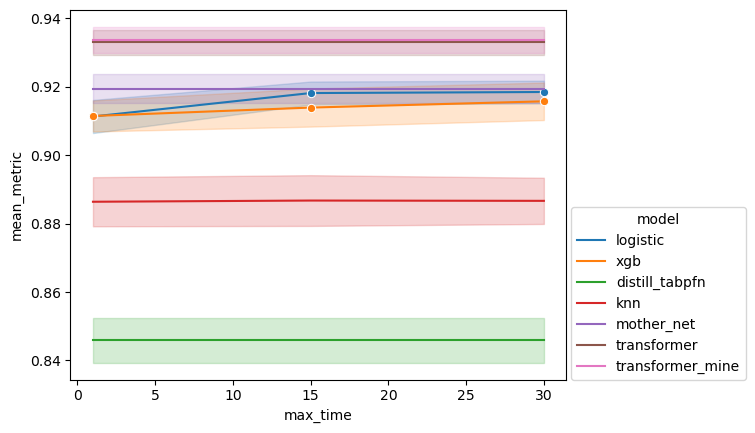

In [37]:
compare_splits = results_combined.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index()

import seaborn as sns
varies_over_time = ['logistic', 'xgb']
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]

color_palette = sns.color_palette()
ax = sns.lineplot(compare_splits_varies, x="max_time", y="mean_metric", hue="model", errorbar="sd", marker="o", palette=color_palette[:len(varies_over_time)])

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", errorbar="sd", ax=ax, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
sns.move_legend(ax, (1.01, 0))
